loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Unique Classes Found in Masks: [0 1]
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Unique Classes Found in Masks: [0 1]
Epoch 1/20


c:\Users\sowmiyasagadevan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 898ms/step - accuracy: 0.7876 - loss: 0.8099 - val_accuracy: 0.8047 - val_loss: 0.5728 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 870ms/step - accuracy: 0.8432 - loss: 0.5197 - val_accuracy: 0.8265 - val_loss: 0.5124 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 886ms/step - accuracy: 0.8407 - loss: 0.4723 - val_accuracy: 0.8265 - val_loss: 0.4459 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 809ms/step - accuracy: 0.8545 - loss: 0.3965 - val_accuracy: 0.8265 - val_loss: 0.4500 - learning_rate: 0.0010
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 862ms/step - accuracy: 0.8315 - loss: 0.4226 - val_accuracy: 0.8265 - val_loss: 0.4018 - learning_rate: 0.0010
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 950ms/step - accuracy: 0.8641 - loss: 0.3517 - val_accuracy: 0.8265 - val_loss: 0.3962 - learning_rate: 0.0010
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 900ms/step - accuracy: 0.8415 - loss: 0.3824 - val_

c:\Users\sowmiyasagadevan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


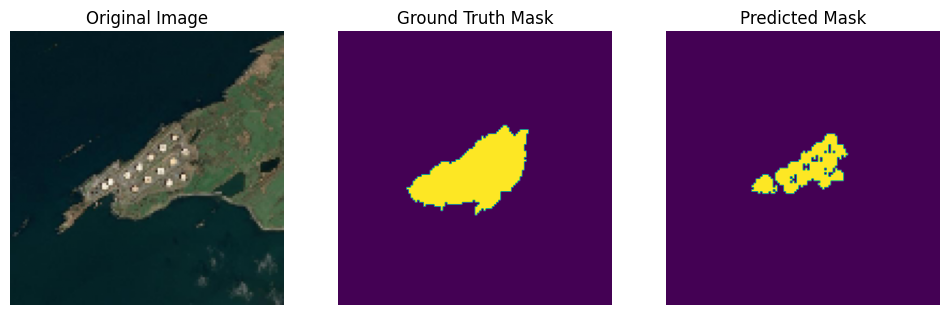

In [7]:
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pycocotools.coco import COCO
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# U-Net Model
def unet_model(input_shape, num_classes):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)

    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)

    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Load dataset from COCO format
def load_data_from_coco(image_dir, annotation_file, input_size, num_classes):
    coco = COCO(annotation_file)
    image_ids = coco.getImgIds()

    images, masks = [], []
    for image_id in image_ids:
        img_info = coco.loadImgs(image_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, input_size)

        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)
        mask = np.zeros((input_size[0], input_size[1]), dtype=np.uint8)

        for ann in anns:
            mask = np.maximum(mask, cv2.resize(coco.annToMask(ann), input_size))

        images.append(img)
        masks.append(mask)

    images = np.array(images) / 255.0
    masks = np.array(masks)

    # Verify unique classes in masks
    unique_classes = np.unique(masks)
    print(f"Unique Classes Found in Masks: {unique_classes}")

    # One-hot encode masks
    masks = np.eye(num_classes)[masks]
    masks = masks.reshape(-1, input_size[0], input_size[1], num_classes)

    return images, masks

# Paths
train_image_dir = r"C:\Users\sowmiyasagadevan\Downloads\oil refineries.v1i.coco-segmentation\train"
train_annotation_file = r"C:\Users\sowmiyasagadevan\Downloads\oil refineries.v1i.coco-segmentation\train.coco.json"
val_image_dir = r"C:\Users\sowmiyasagadevan\Downloads\oil refineries.v1i.coco-segmentation\val"
val_annotation_file = r"C:\Users\sowmiyasagadevan\Downloads\oil refineries.v1i.coco-segmentation\val.coco.json"
# Load data
input_shape = (128, 128, 3)
num_classes = 4

X_train, Y_train = load_data_from_coco(train_image_dir, train_annotation_file, (128, 128), num_classes)
X_val, Y_val = load_data_from_coco(val_image_dir, val_annotation_file, (128, 128), num_classes)

# Model
model = unet_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler]
)

# Debugging Prediction
sample_image = X_val[0]
sample_mask = Y_val[0]
predicted_mask = model.predict(sample_image[np.newaxis, ...])[0]
predicted_mask = np.argmax(predicted_mask, axis=-1)

# Visualize Predictions
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title('Original Image')
plt.axis('off')

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask.argmax(axis=-1), cmap='viridis')
plt.title('Ground Truth Mask')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()
